# PA Quantum Neuron

Build a classical neuron with a quantum circuit

In [7]:
from colorama import Fore, Back, Style 

import numpy as numpy
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.math import requires_grad

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

from math import pi


# Quantum

In [8]:
max_iterations = 50
loop_count = 13

In [9]:

dev_1 = qml.device('default.qubit', wires=2)
dev_2 = qml.device('default.qubit', wires=2)
dev_3 = qml.device('default.qubit', wires=2)

## Classifier 1
init_weights_1 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_1)
def circuit_1(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RY(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_1(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_1(weights, data) + bias


## Classifier 2
init_weights_2 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_2)
def circuit_2(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=0) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])

    return qml.expval(qml.PauliZ(0))

def vc_classifier_2(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_2(weights, data) + bias
  

## Classifier 3
init_weights_3 = (0.01 * np.random.randn(6), 0.0)

@qml.qnode(dev_3)
def circuit_3(weights, data):
    qml.Hadamard(0)
    qml.Hadamard(1)
    
    qml.RY(data[0], wires=0) # input feature 1
    qml.RX(data[1], wires=1) # input feature 2
    
    qml.CNOT(wires=[0, 1])
    
    qml.Rot(weights[0], weights[1], weights[2], wires=0)
    qml.Rot(weights[3], weights[4], weights[5], wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliZ(0))

def vc_classifier_3(var, data):
    weights = var[0]
    bias = var[1]
    return circuit_3(weights, data) + bias


## generic
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cost(vc_classifier, weights, datas, labels):
    predictions = [vc_classifier(weights, f) for f in datas]
    return square_loss(labels, predictions)

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss
  
def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(len(costs)), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()

# init weights
# var_init = (0.01 * np.random.randn(1, 2, 3), 0.0)


In [10]:
def vc_quantum(vc_classifier, init_weights, x_train, x_test, X, y_train, y_test, Y):
  opt = NesterovMomentumOptimizer(0.01)
  batch_size = 5
  var = init_weights
  iterations = max_iterations
  costs = np.zeros(iterations) 

  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, len(x_train), (batch_size,))
      feats_train_batch = x_train[batch_index]
      Y_train_batch = y_train[batch_index]
      var, stepCost = opt.step_and_cost(lambda v: cost(vc_classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(vc_classifier(var, f)) for f in x_train]
      predictions_val = [np.sign(vc_classifier(var, f)) for f in x_test]
      predictions_all = [np.sign(vc_classifier(var, f)) for f in X]

      # Compute accuracy on train and validation set
      acc_train = accuracy(y_train, predictions_train)
      acc_val = accuracy(y_test, predictions_val)
      acc_all = accuracy(Y, predictions_all)

      # gather informations for plotting
      costs[it] = cost(vc_classifier, var, X, Y)

      print(
          "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f} | Acc all: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val, acc_all)
      )
  
  return [var, acc_val]

# plot costs
# plot_costs(costs, 0)

Loop count: 0


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4288601 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4295963 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4293175 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4284547 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     5 | Cost: 0.4247141 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     6 | Cost: 0.4242188 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     7 | Cost: 0.4263956 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4267762 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4283763 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:    10 | Cost: 0.4296687 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:    11 | Cost: 0.4309707 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2166645 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.2156001 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2143695 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2135161 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2156009 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2234337 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.2358435 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.5900000 
Iter:     8 | Cost: 1.2480535 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:     9 | Cost: 1.2496880 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6100000 
Iter:    10 | Cost: 1.2475894 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6100000 
Iter:    11 | Cost: 1.2439668 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6808911 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6830875 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6854274 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6885566 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     5 | Cost: 1.6876688 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     6 | Cost: 1.6871231 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     7 | Cost: 1.6890708 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     8 | Cost: 1.6928270 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     9 | Cost: 1.6908754 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    10 | Cost: 1.6857448 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:    11 | Cost: 1.6829427 | Acc trai

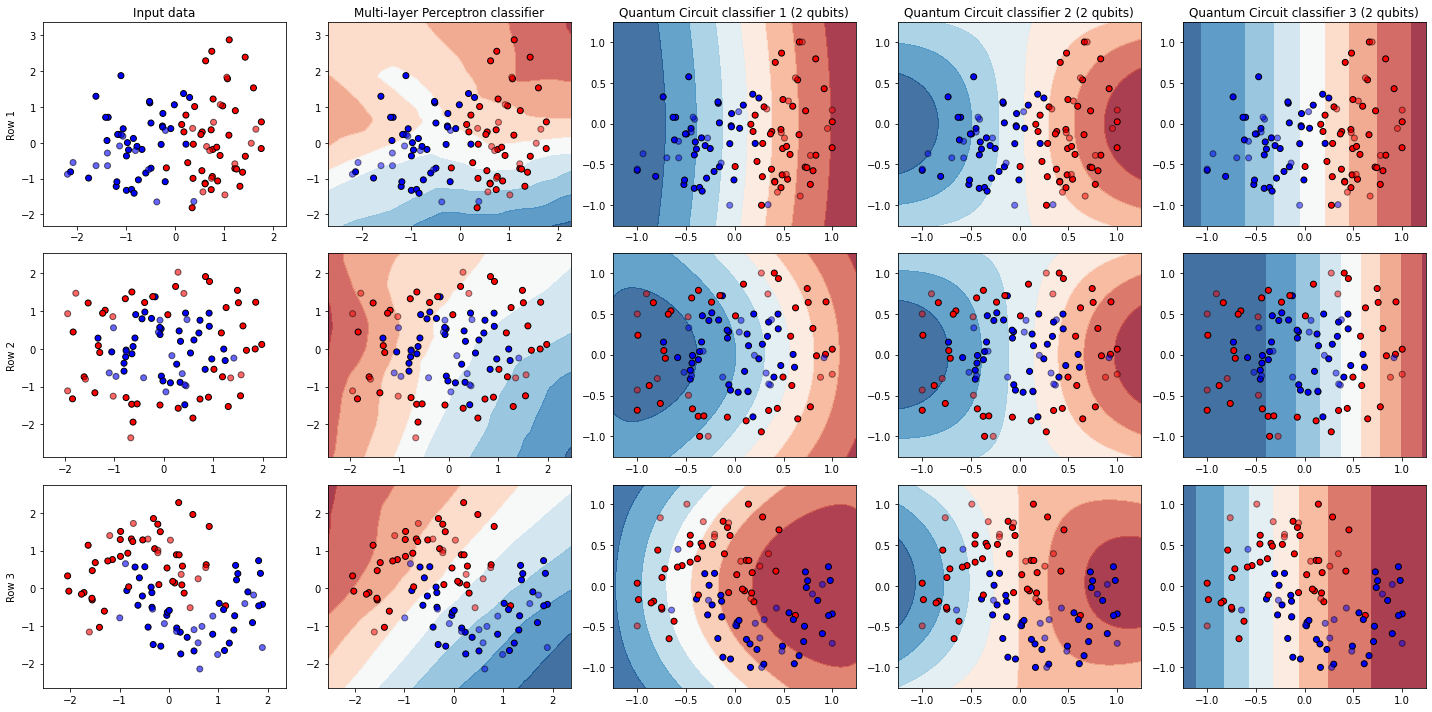

Loop count: 1


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4280644 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4215246 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4185298 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4168883 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     5 | Cost: 0.4167848 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     6 | Cost: 0.4167124 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     7 | Cost: 0.4166267 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4169216 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4181275 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4186007 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4188772 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2206150 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2248096 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4600000 
Iter:     3 | Cost: 1.2282326 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     4 | Cost: 1.2326613 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     5 | Cost: 1.2335395 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:     6 | Cost: 1.2288578 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     7 | Cost: 1.2259302 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     8 | Cost: 1.2173887 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4600000 
Iter:     9 | Cost: 1.2113691 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:    10 | Cost: 1.2053354 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.2014306 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6808854 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6807903 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6805988 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6818846 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     5 | Cost: 1.6844290 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     6 | Cost: 1.6918888 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     7 | Cost: 1.6989426 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.7181198 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     9 | Cost: 1.7468828 | Acc train: 0.2800000 | Acc val: 0.3600000 | Acc all: 0.3100000 
Iter:    10 | Cost: 1.7784657 | Acc train: 0.2800000 | Acc val: 0.3600000 | Acc all: 0.3100000 
Iter:    11 | Cost: 1.7968290 | Acc trai

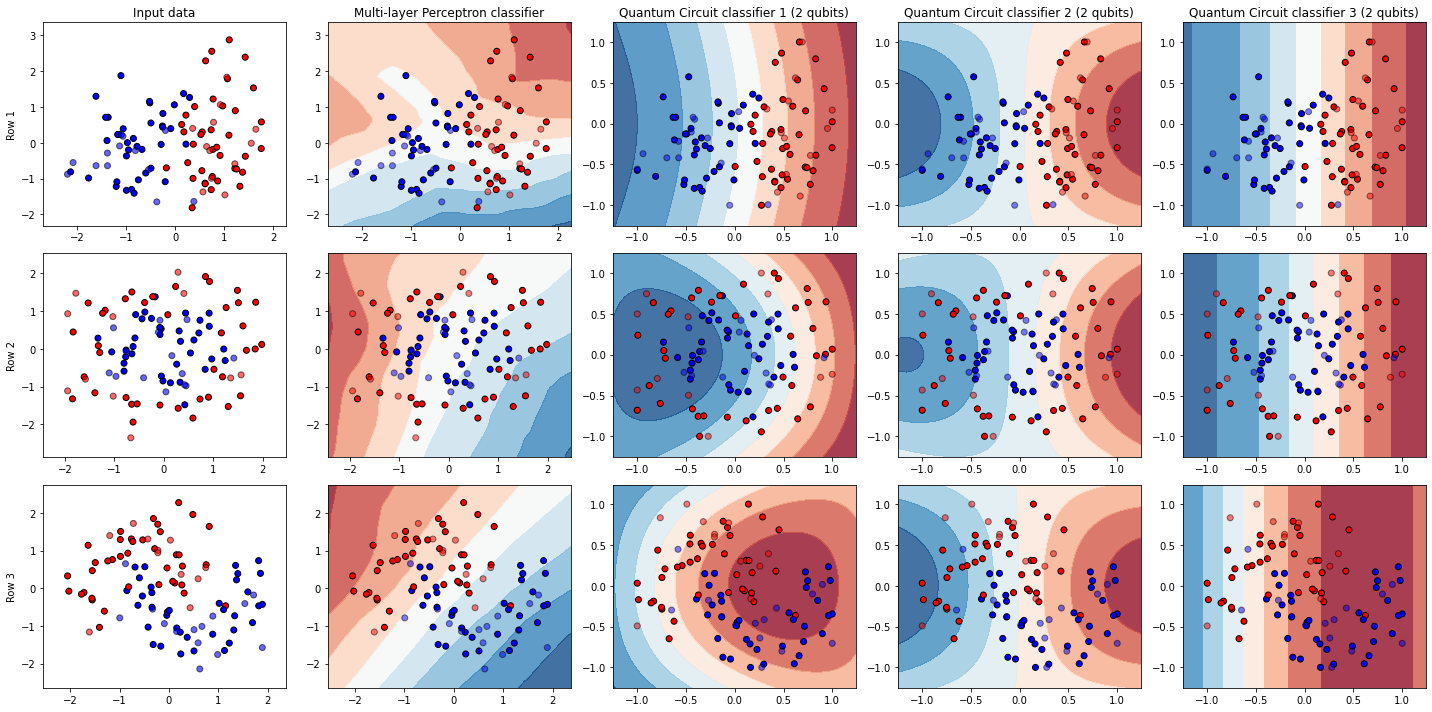

Loop count: 2


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4287109 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4250217 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4211200 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     4 | Cost: 0.4178115 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4170529 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     6 | Cost: 0.4174539 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     7 | Cost: 0.4193463 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4202045 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4228343 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4261539 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4298385 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2167514 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.2156460 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2148438 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     4 | Cost: 1.2129751 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2112471 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2094890 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2078840 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.2065584 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.2056719 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.2043835 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:    11 | Cost: 1.2000159 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6796307 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6797424 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6796779 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6795522 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.6806814 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     6 | Cost: 1.6801893 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     7 | Cost: 1.6802560 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.6829251 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     9 | Cost: 1.6828413 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.6845389 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    11 | Cost: 1.6909201 | Acc trai

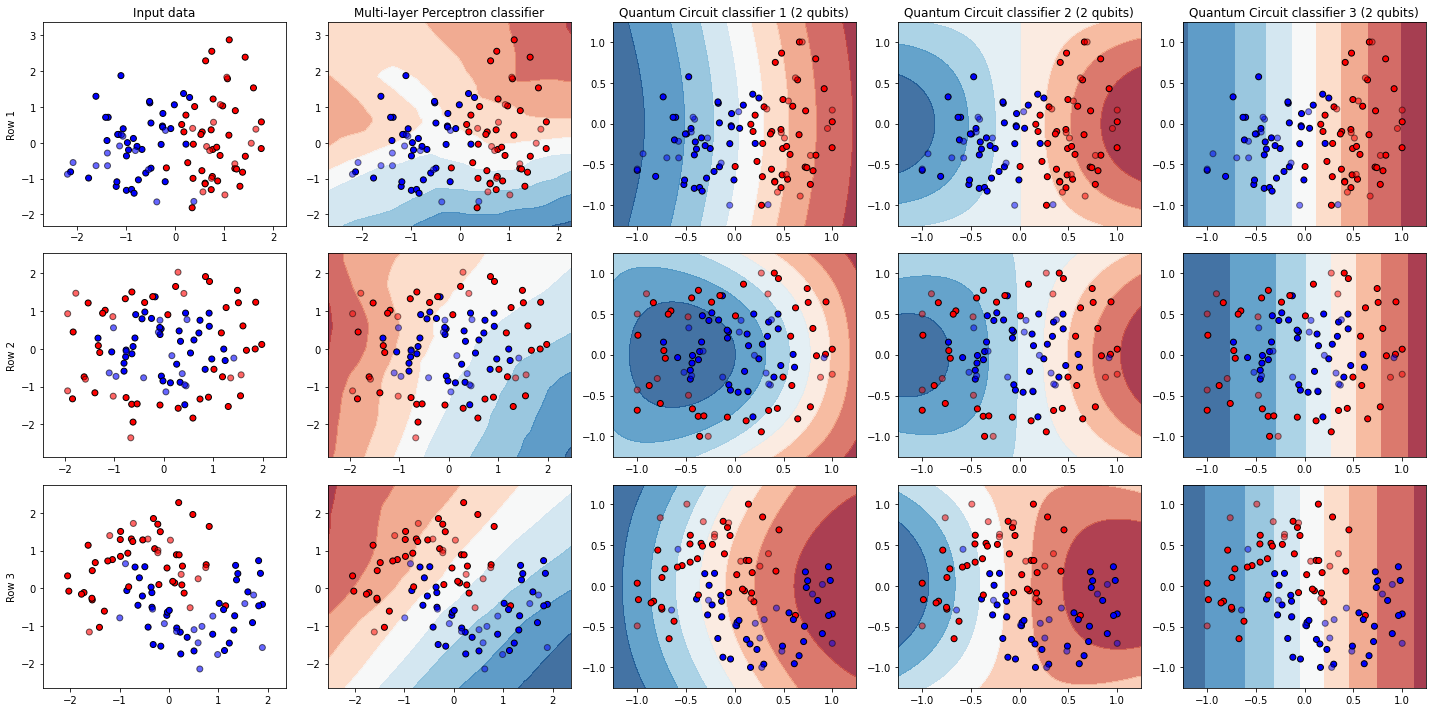

Loop count: 3


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4270754 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4258572 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4223923 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     4 | Cost: 0.4193365 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4181813 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4172387 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4170753 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4171840 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4174487 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4176462 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4172297 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2184501 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2201929 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.2198469 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.2206907 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.4800000 
Iter:     5 | Cost: 1.2237248 | Acc train: 0.4933333 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     6 | Cost: 1.2281451 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4500000 
Iter:     7 | Cost: 1.2312084 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:     8 | Cost: 1.2339230 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:     9 | Cost: 1.2310606 | Acc train: 0.4800000 | Acc val: 0.3600000 | Acc all: 0.4400000 
Iter:    10 | Cost: 1.2352877 | Acc train: 0.4666667 | Acc val: 0.3200000 | Acc all: 0.4400000 
Iter:    11 | Cost: 1.2302743 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6799103 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6811493 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6841310 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6896205 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     5 | Cost: 1.6933545 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     6 | Cost: 1.7031650 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7149233 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.7177100 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     9 | Cost: 1.7147417 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.7085902 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    11 | Cost: 1.6993981 | Acc trai

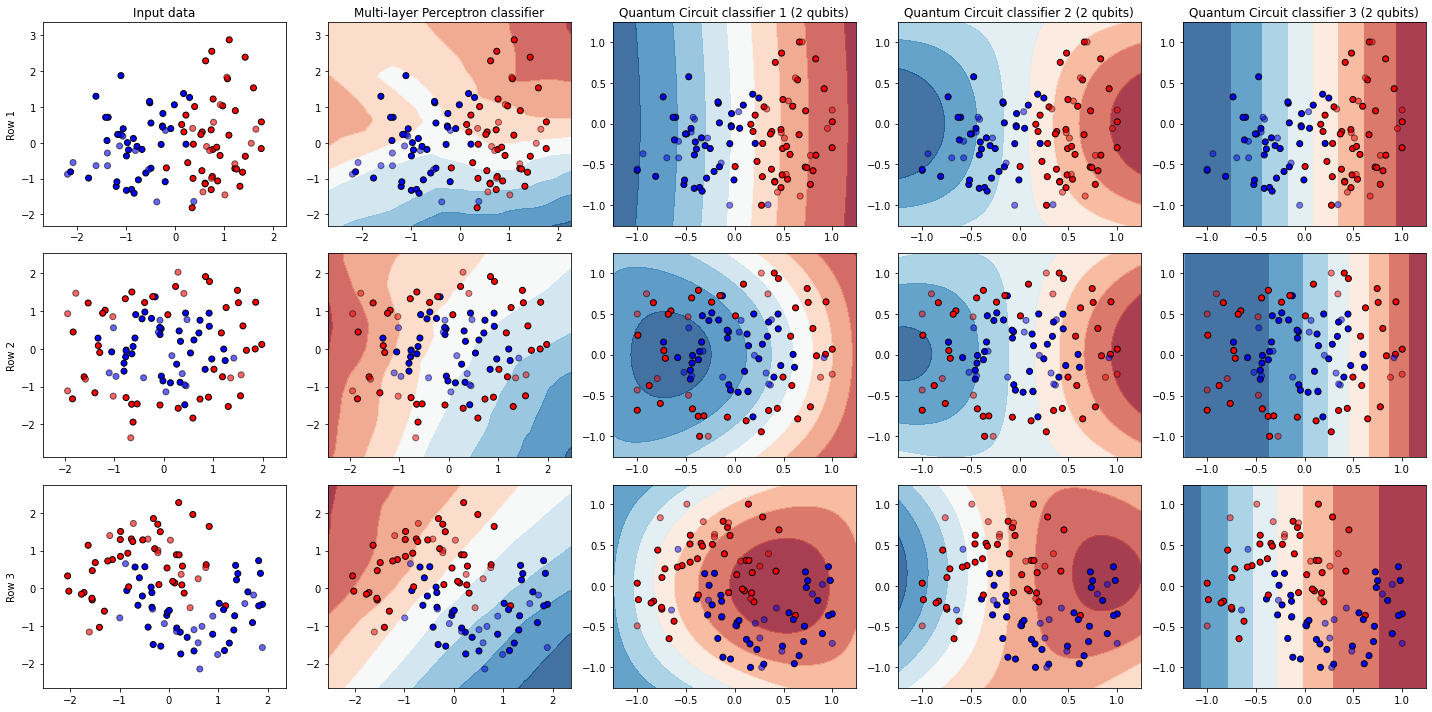

Loop count: 4


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4268151 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4218525 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     3 | Cost: 0.4188384 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4176870 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4169474 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     6 | Cost: 0.4169989 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     7 | Cost: 0.4174457 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4181502 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4180316 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    10 | Cost: 0.4177623 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    11 | Cost: 0.4178965 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2177002 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2169565 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2150759 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2153010 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2176709 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2206791 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.2258531 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     8 | Cost: 1.2267528 | Acc train: 0.5733333 | Acc val: 0.5200000 | Acc all: 0.5600000 
Iter:     9 | Cost: 1.2250009 | Acc train: 0.5733333 | Acc val: 0.5200000 | Acc all: 0.5600000 
Iter:    10 | Cost: 1.2174356 | Acc train: 0.5600000 | Acc val: 0.5200000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.2081989 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6803771 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6821035 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6839392 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6837748 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     5 | Cost: 1.6834061 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     6 | Cost: 1.6800173 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     7 | Cost: 1.6783852 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.6779762 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     9 | Cost: 1.6784982 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:    10 | Cost: 1.6814599 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    11 | Cost: 1.6877276 | Acc trai

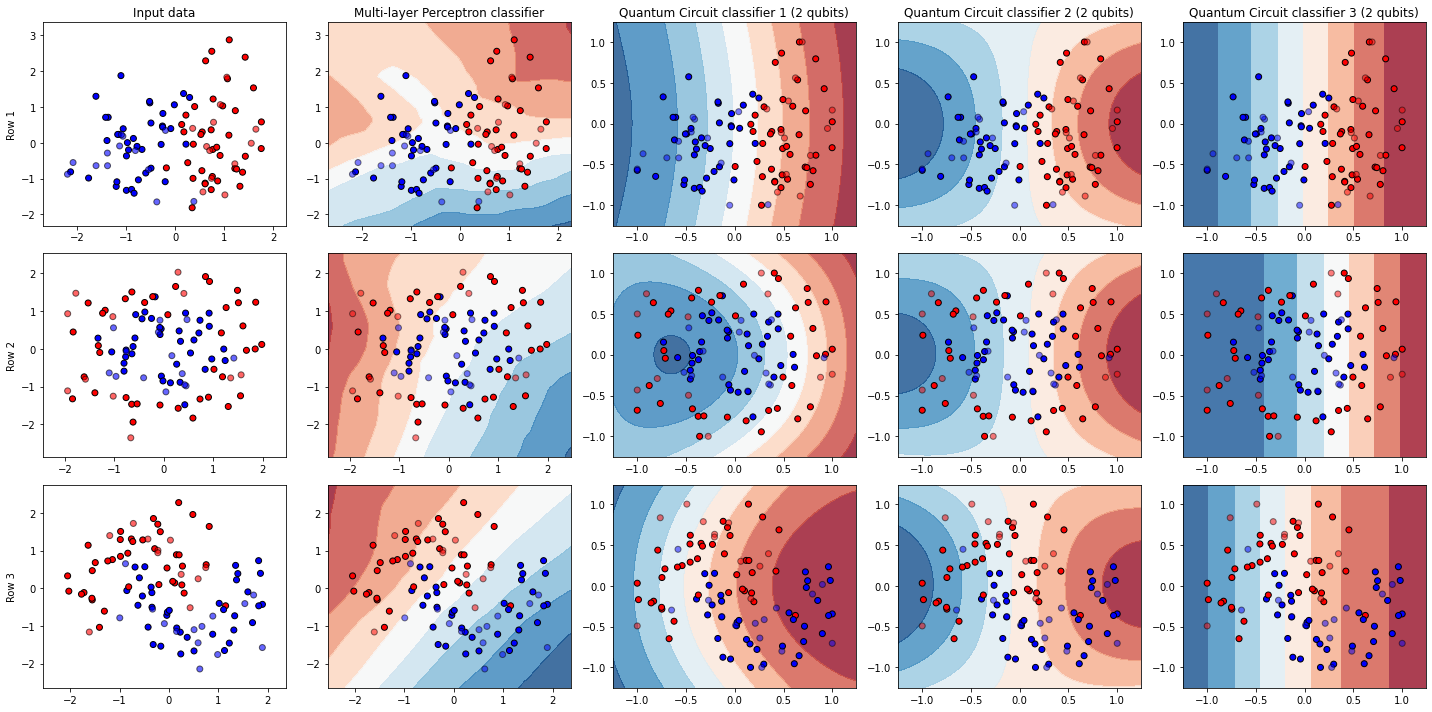

Loop count: 5


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4287805 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4318066 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4347174 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9000000 
Iter:     4 | Cost: 0.4417612 | Acc train: 0.8800000 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     5 | Cost: 0.4476902 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:     6 | Cost: 0.4542025 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:     7 | Cost: 0.4562308 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:     8 | Cost: 0.4566469 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:     9 | Cost: 0.4535294 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:    10 | Cost: 0.4506929 | Acc train: 0.8666667 | Acc val: 0.8800000 | Acc all: 0.8800000 
Iter:    11 | Cost: 0.4520411 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2170125 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.2158963 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2148990 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2131380 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2113554 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2091987 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     7 | Cost: 1.2073300 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     8 | Cost: 1.2047308 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.2010712 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.1982079 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.1954376 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6816754 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6857929 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6962213 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     4 | Cost: 1.7052582 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.7148706 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.7201521 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     7 | Cost: 1.7180348 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.7074966 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.6993412 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:    10 | Cost: 1.6889578 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:    11 | Cost: 1.6778340 | Acc trai

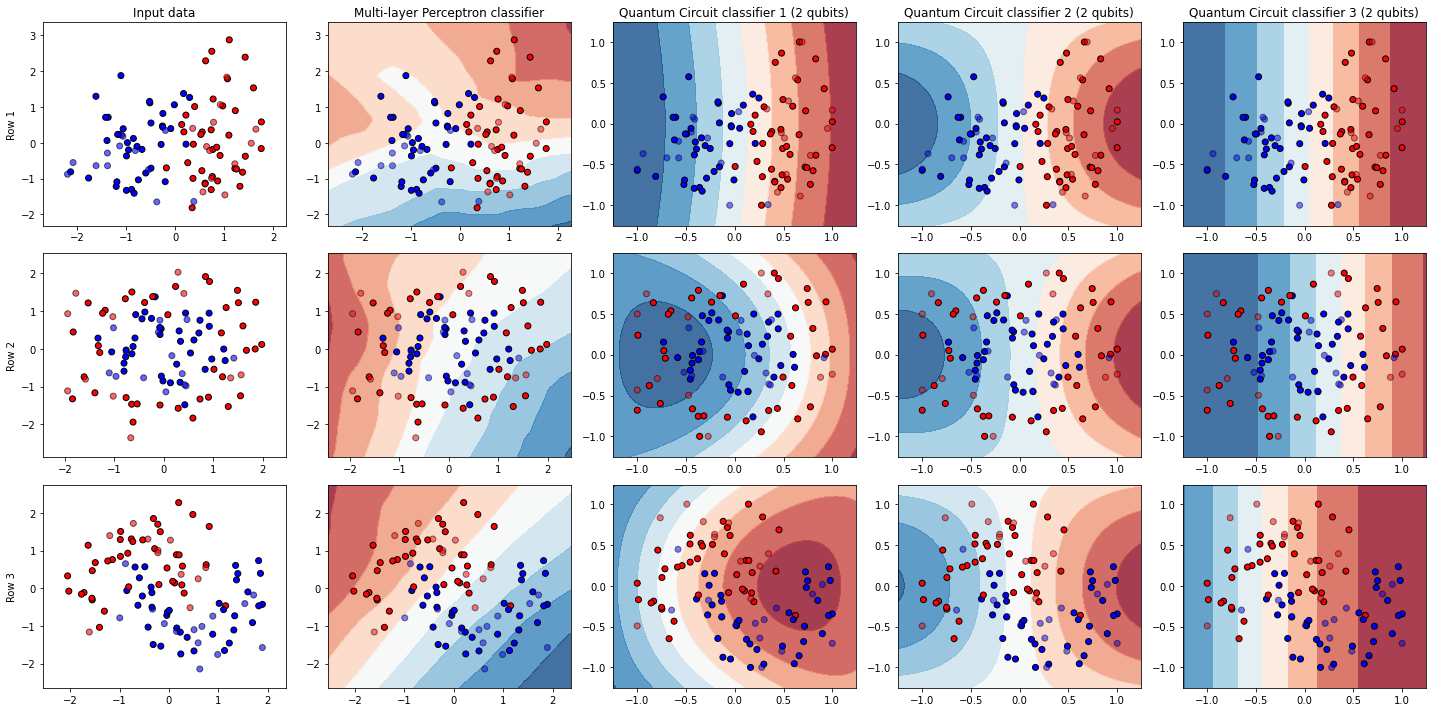

Loop count: 6


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4299349 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4270160 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     3 | Cost: 0.4252950 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     4 | Cost: 0.4223030 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     5 | Cost: 0.4194303 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4183531 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4174419 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4174753 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4175877 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4187070 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4191944 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2180242 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2158830 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2145337 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2138102 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2149314 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2194584 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.2307294 | Acc train: 0.5866667 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2439873 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:     9 | Cost: 1.2527904 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6100000 
Iter:    10 | Cost: 1.2534767 | Acc train: 0.6133333 | Acc val: 0.5600000 | Acc all: 0.6100000 
Iter:    11 | Cost: 1.2543848 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6804824 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6866825 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.7022622 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.7092879 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.7194331 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.7410367 | Acc train: 0.2933333 | Acc val: 0.4000000 | Acc all: 0.3200000 
Iter:     7 | Cost: 1.7692643 | Acc train: 0.2666667 | Acc val: 0.3600000 | Acc all: 0.3000000 
Iter:     8 | Cost: 1.8049236 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.8326117 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.8572403 | Acc train: 0.3200000 | Acc val: 0.4000000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.8554281 | Acc trai

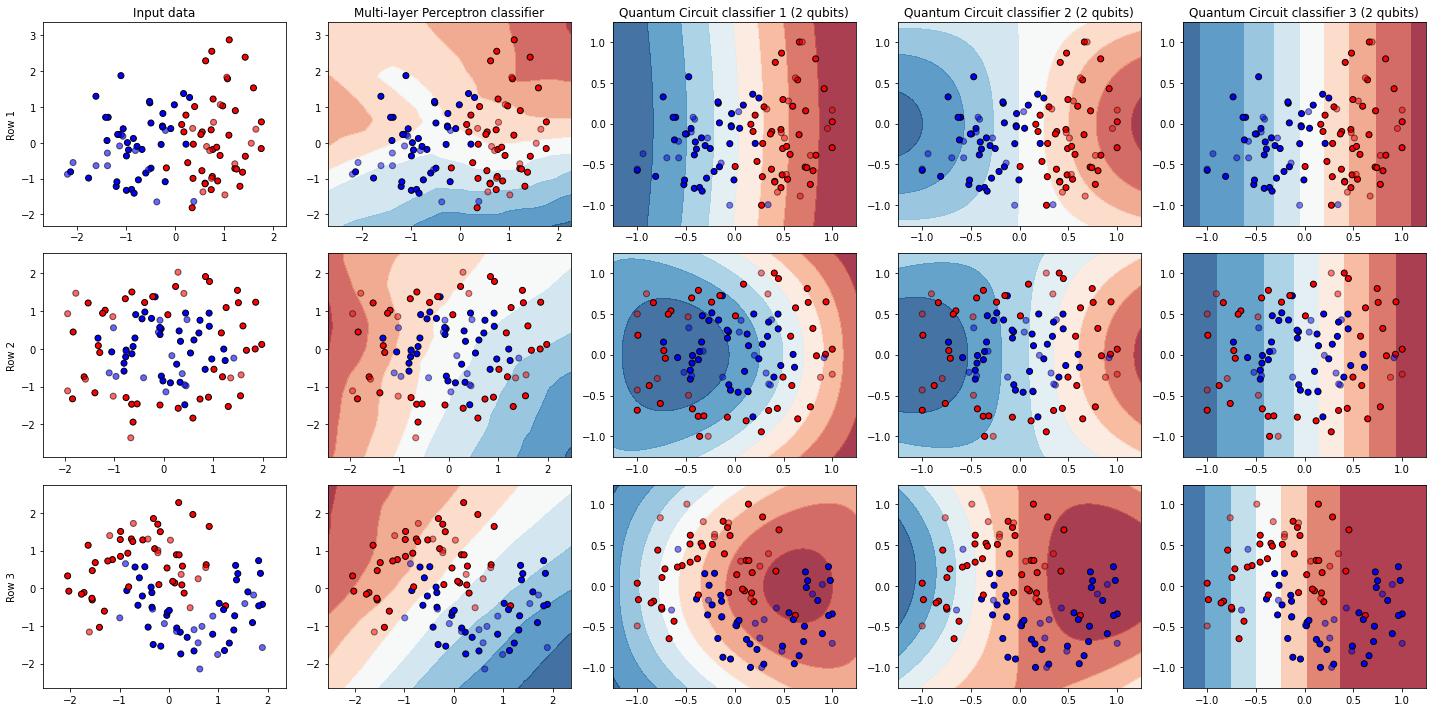

Loop count: 7


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4317365 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4301856 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4321111 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4321700 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     5 | Cost: 0.4308883 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     6 | Cost: 0.4266605 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4235221 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     8 | Cost: 0.4216488 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     9 | Cost: 0.4214917 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:    10 | Cost: 0.4198955 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:    11 | Cost: 0.4175618 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2187344 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2206442 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.2215536 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.2236515 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.4700000 
Iter:     5 | Cost: 1.2197202 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     6 | Cost: 1.2164880 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2145104 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2134809 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     9 | Cost: 1.2123654 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.2137251 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:    11 | Cost: 1.2124782 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6802854 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6824833 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6863074 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6903104 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     5 | Cost: 1.6960210 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     6 | Cost: 1.7041477 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7063919 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.7080525 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.7157216 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.7206427 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3200000 
Iter:    11 | Cost: 1.7173608 | Acc trai

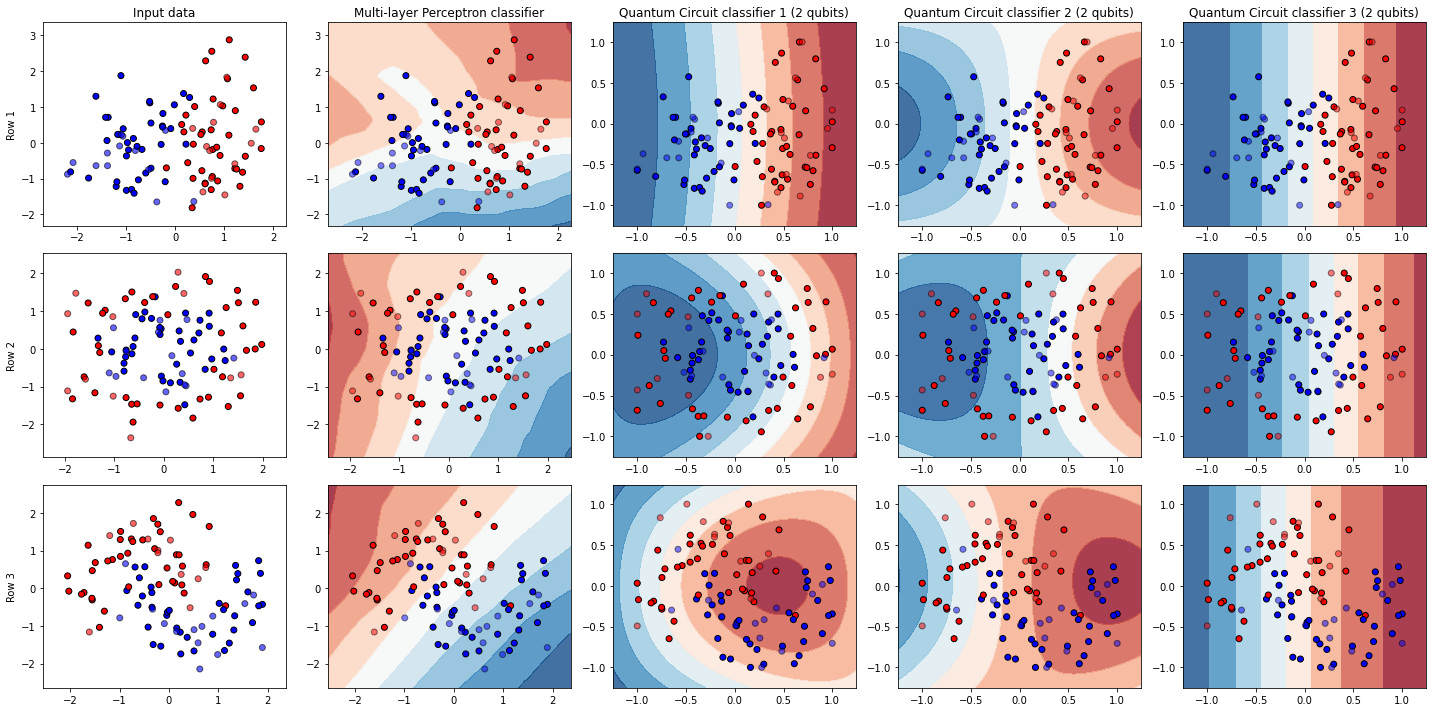

Loop count: 8


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4278435 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4284064 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4267363 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     4 | Cost: 0.4230367 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     5 | Cost: 0.4192146 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4174652 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     7 | Cost: 0.4169626 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     8 | Cost: 0.4169441 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:     9 | Cost: 0.4173142 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    10 | Cost: 0.4184952 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    11 | Cost: 0.4200834 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2204180 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     2 | Cost: 1.2203842 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     3 | Cost: 1.2195431 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     4 | Cost: 1.2182672 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5000000 
Iter:     5 | Cost: 1.2146724 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2104625 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2079701 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     8 | Cost: 1.2055133 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     9 | Cost: 1.2054263 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:    10 | Cost: 1.2032368 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:    11 | Cost: 1.2024284 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6797289 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6797510 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6795480 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     4 | Cost: 1.6801701 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     5 | Cost: 1.6800891 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     6 | Cost: 1.6795601 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     7 | Cost: 1.6795426 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.6802542 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.6829269 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.6899562 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    11 | Cost: 1.7096487 | Acc trai

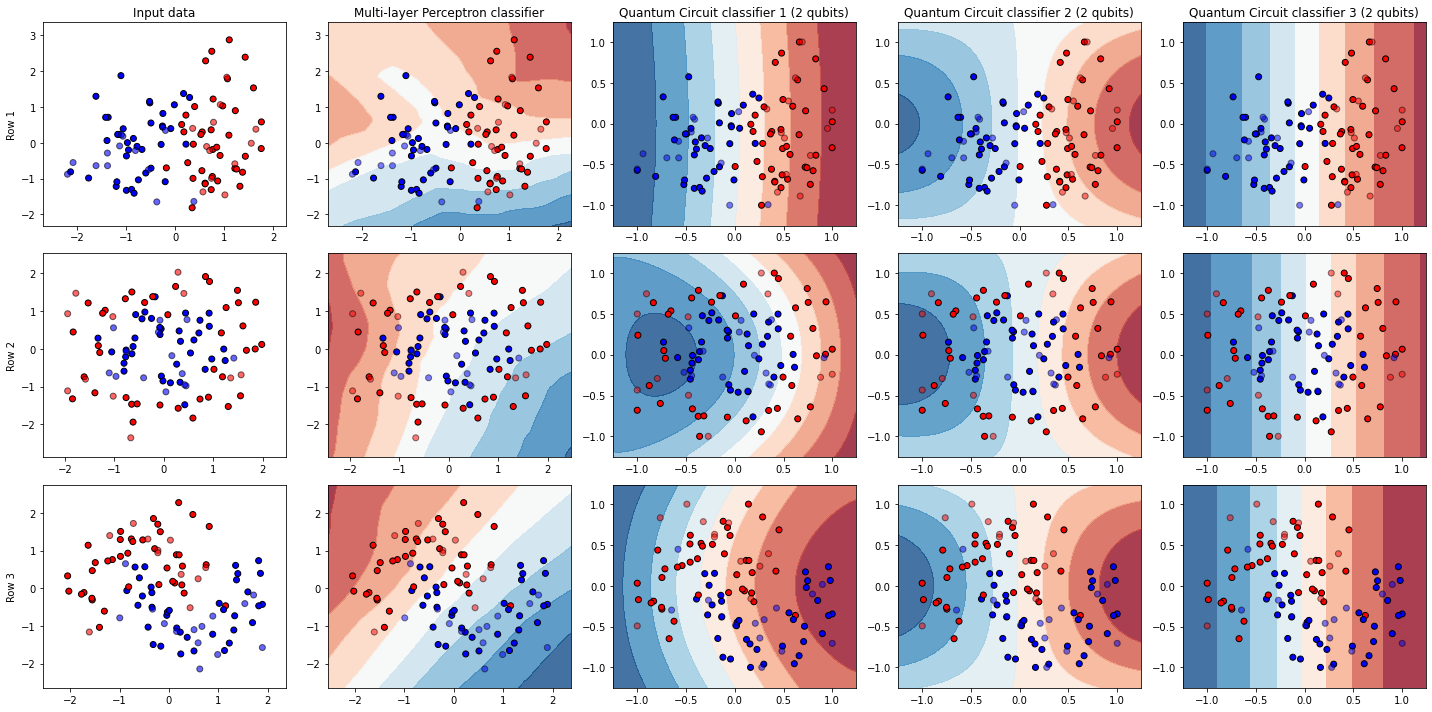

Loop count: 9


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4298957 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4340133 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9100000 
Iter:     3 | Cost: 0.4349322 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9000000 
Iter:     4 | Cost: 0.4308191 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     5 | Cost: 0.4305103 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     6 | Cost: 0.4346663 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9000000 
Iter:     7 | Cost: 0.4318112 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     8 | Cost: 0.4335151 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     9 | Cost: 0.4371824 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:    10 | Cost: 0.4417524 | Acc train: 0.8800000 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:    11 | Cost: 0.4442383 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2179527 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2156735 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2147814 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2144115 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2155491 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     6 | Cost: 1.2193709 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:     7 | Cost: 1.2317055 | Acc train: 0.5866667 | Acc val: 0.5200000 | Acc all: 0.5800000 
Iter:     8 | Cost: 1.2416525 | Acc train: 0.6000000 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:     9 | Cost: 1.2404839 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:    10 | Cost: 1.2418598 | Acc train: 0.6133333 | Acc val: 0.5200000 | Acc all: 0.6000000 
Iter:    11 | Cost: 1.2401390 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6795940 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6800759 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     3 | Cost: 1.6829895 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6887341 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     5 | Cost: 1.6948063 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     6 | Cost: 1.7019284 | Acc train: 0.3066667 | Acc val: 0.2800000 | Acc all: 0.3100000 
Iter:     7 | Cost: 1.7174373 | Acc train: 0.2933333 | Acc val: 0.3200000 | Acc all: 0.3100000 
Iter:     8 | Cost: 1.7546209 | Acc train: 0.2933333 | Acc val: 0.4000000 | Acc all: 0.3100000 
Iter:     9 | Cost: 1.7785947 | Acc train: 0.3066667 | Acc val: 0.3600000 | Acc all: 0.3100000 
Iter:    10 | Cost: 1.7938912 | Acc train: 0.3066667 | Acc val: 0.3600000 | Acc all: 0.3200000 
Iter:    11 | Cost: 1.8098287 | Acc trai

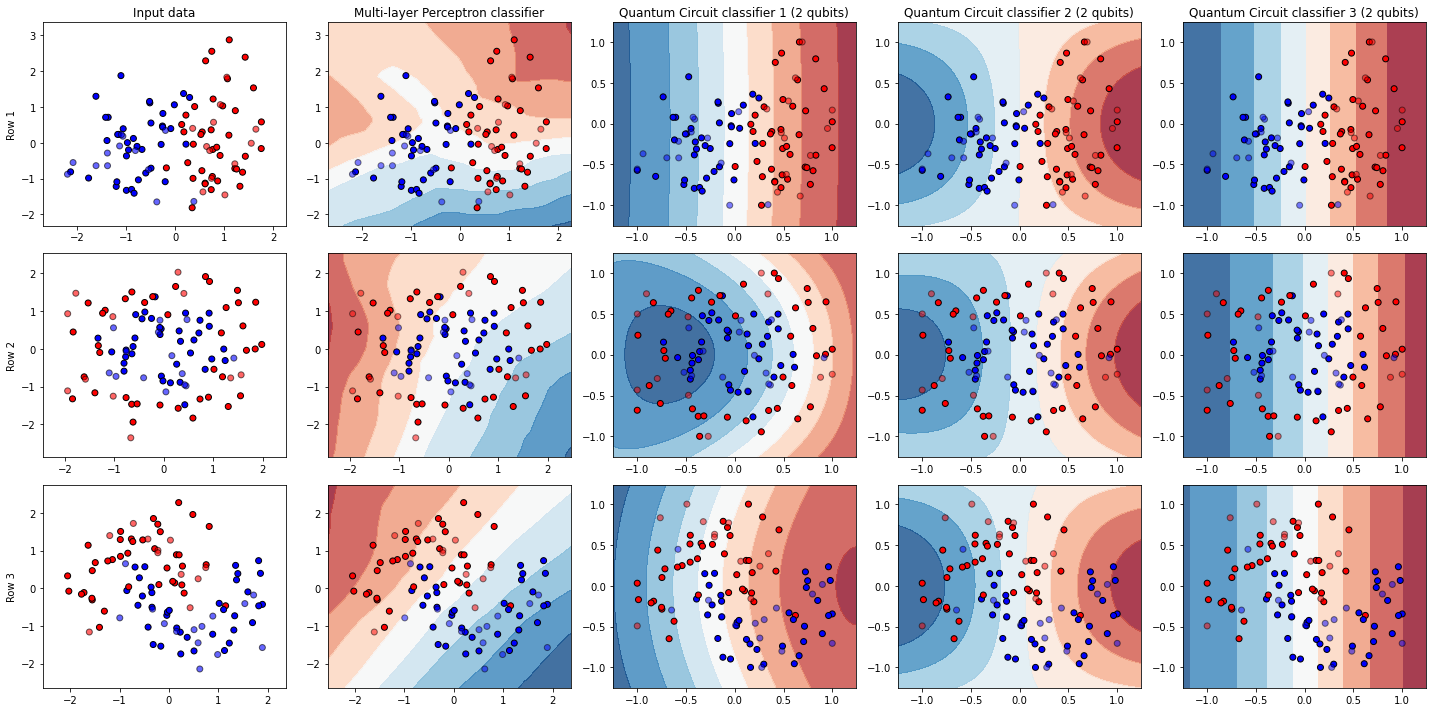

Loop count: 10


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4297151 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     2 | Cost: 0.4298390 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4316082 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4300409 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     5 | Cost: 0.4279756 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     6 | Cost: 0.4283872 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     7 | Cost: 0.4262645 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     8 | Cost: 0.4224570 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     9 | Cost: 0.4199760 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:    10 | Cost: 0.4182748 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4168472 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2167503 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     2 | Cost: 1.2158129 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     3 | Cost: 1.2145796 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2142356 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     5 | Cost: 1.2136344 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     6 | Cost: 1.2118239 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.2103881 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.2083480 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     9 | Cost: 1.2065100 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:    10 | Cost: 1.2035444 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:    11 | Cost: 1.2010721 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6799190 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     2 | Cost: 1.6797172 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6799914 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     4 | Cost: 1.6803806 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     5 | Cost: 1.6792289 | Acc train: 0.3333333 | Acc val: 0.3600000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.6791936 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.6790191 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     8 | Cost: 1.6794664 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     9 | Cost: 1.6820574 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.6876787 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    11 | Cost: 1.6935794 | Acc trai

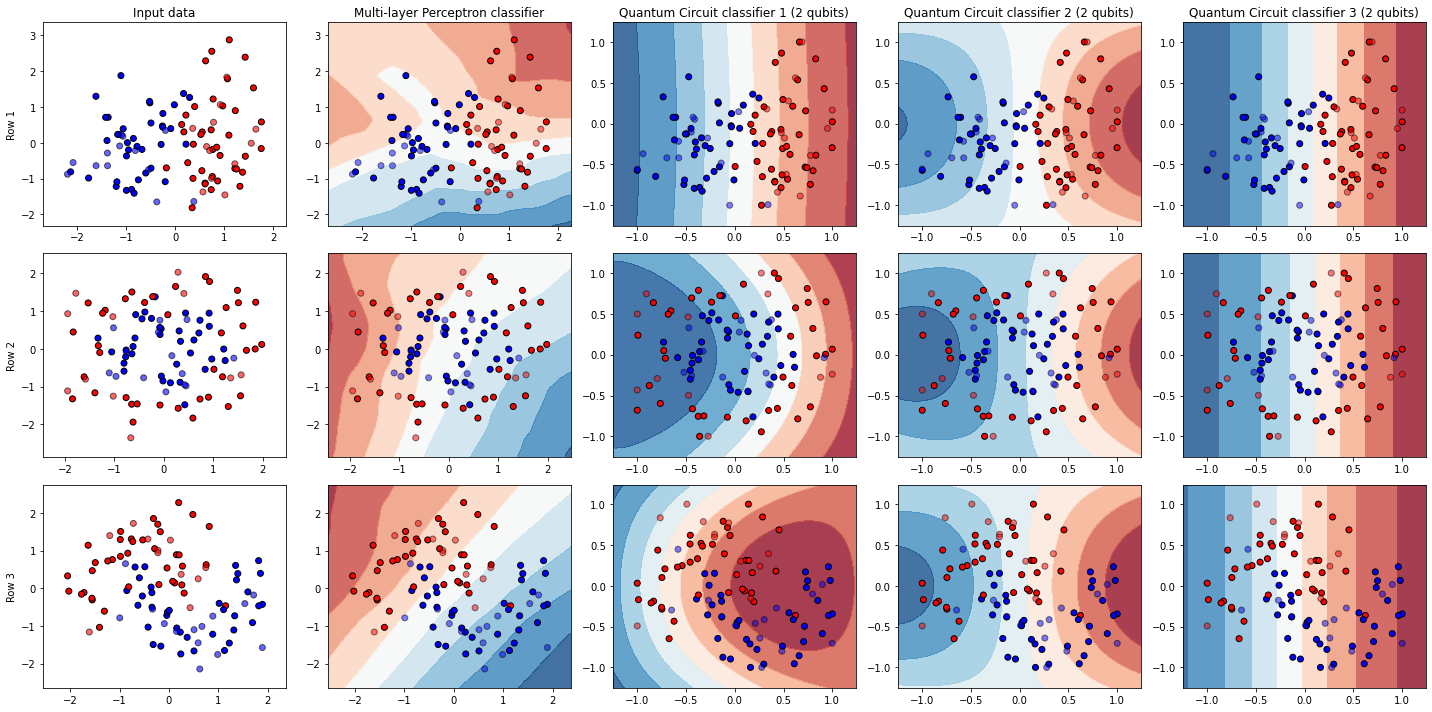

Loop count: 11


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4279219 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     2 | Cost: 0.4297423 | Acc train: 0.9333333 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     3 | Cost: 0.4291464 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     4 | Cost: 0.4270357 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9400000 
Iter:     5 | Cost: 0.4259965 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     6 | Cost: 0.4247011 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9300000 
Iter:     7 | Cost: 0.4213927 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     8 | Cost: 0.4197523 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4196155 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    10 | Cost: 0.4192653 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:    11 | Cost: 0.4196909 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2192914 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2185490 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2149000 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     4 | Cost: 1.2128630 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     5 | Cost: 1.2119893 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     6 | Cost: 1.2091637 | Acc train: 0.5333333 | Acc val: 0.4000000 | Acc all: 0.5100000 
Iter:     7 | Cost: 1.2077430 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     8 | Cost: 1.2076513 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.2067580 | Acc train: 0.5733333 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.2075707 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.2092016 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6795975 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     2 | Cost: 1.6820361 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     3 | Cost: 1.6826176 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     4 | Cost: 1.6805572 | Acc train: 0.3600000 | Acc val: 0.3200000 | Acc all: 0.3500000 
Iter:     5 | Cost: 1.6791806 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3500000 
Iter:     6 | Cost: 1.6794819 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     7 | Cost: 1.6829276 | Acc train: 0.3466667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.6857514 | Acc train: 0.3466667 | Acc val: 0.3600000 | Acc all: 0.3600000 
Iter:     9 | Cost: 1.6865304 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    10 | Cost: 1.6881533 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:    11 | Cost: 1.6857805 | Acc trai

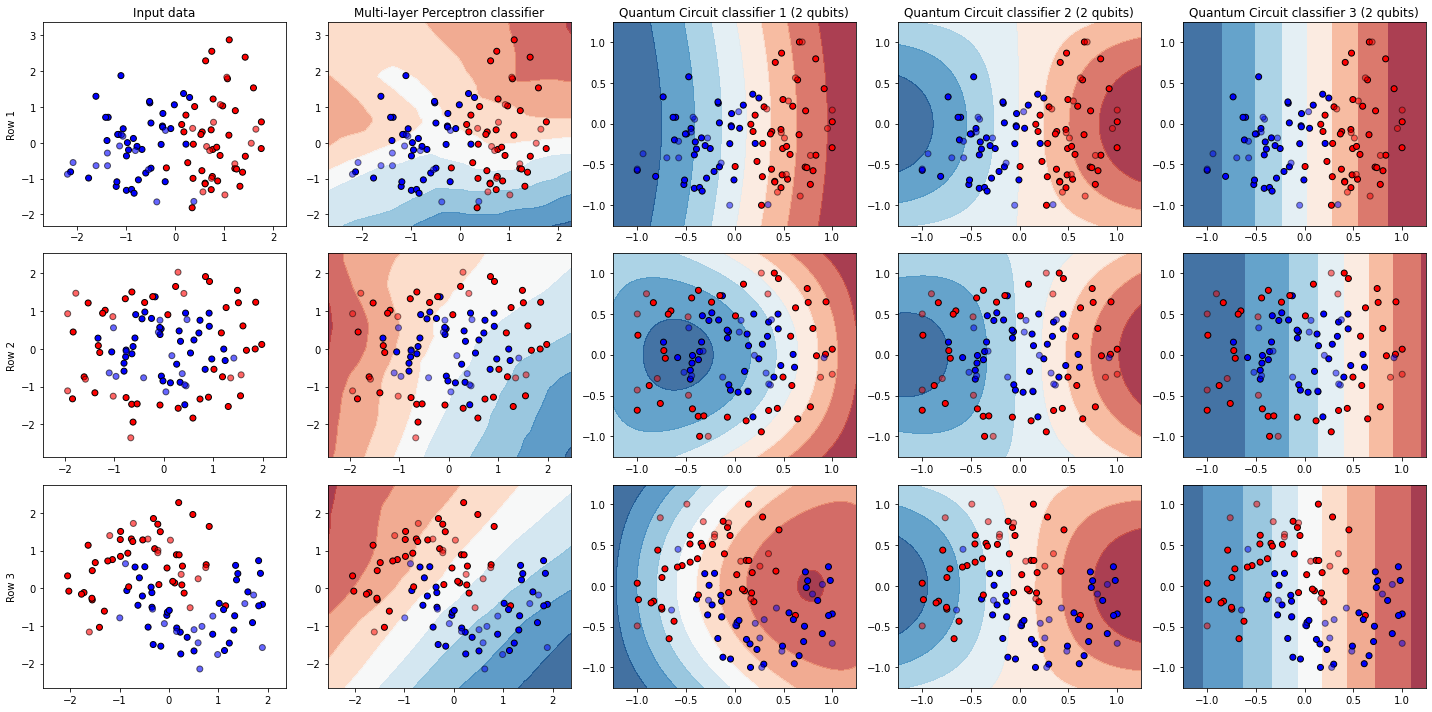

Loop count: 12


C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 0.4346372 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9000000 
Iter:     2 | Cost: 0.4421516 | Acc train: 0.8800000 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     3 | Cost: 0.4468825 | Acc train: 0.8666667 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     4 | Cost: 0.4422501 | Acc train: 0.8800000 | Acc val: 0.9200000 | Acc all: 0.8800000 
Iter:     5 | Cost: 0.4362169 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.8900000 
Iter:     6 | Cost: 0.4290279 | Acc train: 0.9200000 | Acc val: 0.9200000 | Acc all: 0.9200000 
Iter:     7 | Cost: 0.4224798 | Acc train: 0.9200000 | Acc val: 0.9600000 | Acc all: 0.9300000 
Iter:     8 | Cost: 0.4187926 | Acc train: 0.9333333 | Acc val: 0.9600000 | Acc all: 0.9400000 
Iter:     9 | Cost: 0.4169170 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    10 | Cost: 0.4170741 | Acc train: 0.9466667 | Acc val: 0.9600000 | Acc all: 0.9500000 
Iter:    11 | Cost: 0.4176792 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.2183459 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     2 | Cost: 1.2179473 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     3 | Cost: 1.2158428 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     4 | Cost: 1.2135231 | Acc train: 0.5200000 | Acc val: 0.3600000 | Acc all: 0.5200000 
Iter:     5 | Cost: 1.2116089 | Acc train: 0.5333333 | Acc val: 0.3600000 | Acc all: 0.5100000 
Iter:     6 | Cost: 1.2099316 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5300000 
Iter:     7 | Cost: 1.2101612 | Acc train: 0.5333333 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     8 | Cost: 1.2081512 | Acc train: 0.5466667 | Acc val: 0.4400000 | Acc all: 0.5400000 
Iter:     9 | Cost: 1.2081980 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5400000 
Iter:    10 | Cost: 1.2092962 | Acc train: 0.5600000 | Acc val: 0.4800000 | Acc all: 0.5500000 
Iter:    11 | Cost: 1.2082318 | Acc trai

C:\Users\zero\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\zero\anaconda3\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.20.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


Iter:     1 | Cost: 1.6805224 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     2 | Cost: 1.6823463 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     3 | Cost: 1.6900742 | Acc train: 0.3600000 | Acc val: 0.3600000 | Acc all: 0.3700000 
Iter:     4 | Cost: 1.6939027 | Acc train: 0.3733333 | Acc val: 0.3600000 | Acc all: 0.3800000 
Iter:     5 | Cost: 1.7023288 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     6 | Cost: 1.7082634 | Acc train: 0.3333333 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     7 | Cost: 1.7163301 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:     8 | Cost: 1.7119732 | Acc train: 0.3200000 | Acc val: 0.3200000 | Acc all: 0.3400000 
Iter:     9 | Cost: 1.7136733 | Acc train: 0.3066667 | Acc val: 0.3200000 | Acc all: 0.3300000 
Iter:    10 | Cost: 1.7291542 | Acc train: 0.3066667 | Acc val: 0.4000000 | Acc all: 0.3300000 
Iter:    11 | Cost: 1.7452498 | Acc trai

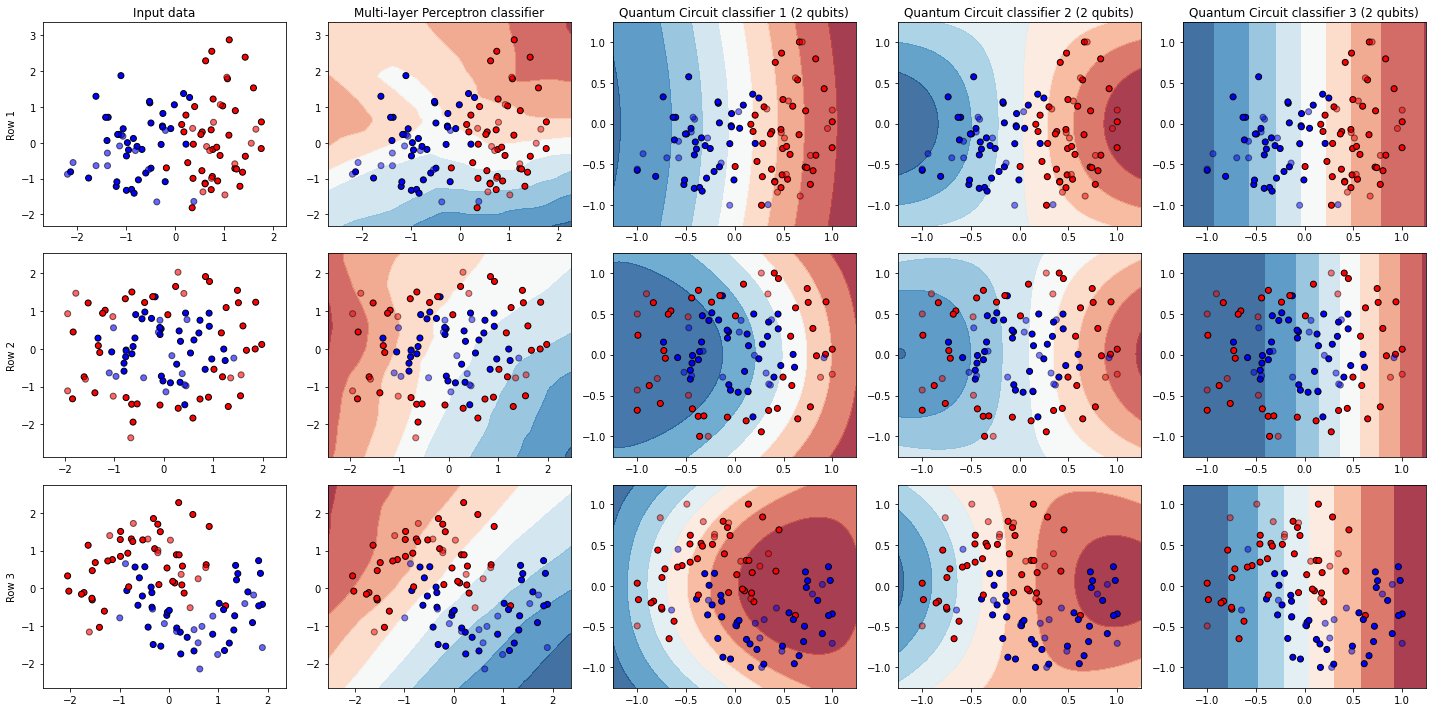

scores: [[[0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]
  [0.56 0.68 0.76]]

 [[0.96 0.4  0.36]
  [0.96 0.6  0.36]
  [0.96 0.6  0.32]
  [0.88 0.56 0.36]
  [0.96 0.56 0.32]
  [0.96 0.44 0.32]
  [0.92 0.68 0.32]
  [0.96 0.56 0.36]
  [0.96 0.52 0.32]
  [0.88 0.64 0.32]
  [0.88 0.44 0.28]
  [0.96 0.64 0.36]
  [0.96 0.48 0.32]]

 [[0.96 0.36 0.32]
  [0.96 0.44 0.32]
  [0.92 0.36 0.32]
  [0.96 0.36 0.4 ]
  [0.96 0.36 0.32]
  [0.92 0.36 0.32]
  [1.   0.44 0.32]
  [0.88 0.44 0.32]
  [1.   0.36 0.32]
  [0.92 0.36 0.32]
  [0.96 0.44 0.36]
  [0.92 0.36 0.36]
  [0.92 0.44 0.32]]

 [[0.96 0.56 0.32]
  [0.96 0.32 0.4 ]
  [0.96 0.48 0.32]
  [0.96 0.52 0.32]
  [0.92 0.48 0.32]
  [0.96 0.44 0.32]
  [0.96 0.48 0.36]
  [0.96 0.36 0.4 ]
  [0.88 0.32 0.32]
  [0.92 0.36 0.32]
  [0.96 0.32 0.32]
  [0.92 0.6  0.4 ]
  [0.92 0.48 0.36

In [11]:
halfPi = pi/2
# h = 0.02  # step size in the mesh
h = 0.03  # step size in the mesh
n_samples = 100

names = [
    "Multi-layer Perceptron classifier",
    # "Linear SVM",
    "Quantum Circuit classifier 1 (2 qubits)",
    "Quantum Circuit classifier 2 (2 qubits)",
    "Quantum Circuit classifier 3 (2 qubits)",
]

classifiers = [
  MLPClassifier(random_state=1, max_iter=max_iterations, 
                    solver="sgd", nesterovs_momentum=True),
  # SVC(kernel="linear", C=0.025),
  [vc_quantum, vc_classifier_1, init_weights_1, circuit_1],
  [vc_quantum, vc_classifier_2, init_weights_2, circuit_2],
  [vc_quantum, vc_classifier_3, init_weights_3, circuit_3],
]

X, y = make_classification(
    n_samples=n_samples,
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = numpy.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    linearly_separable,
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
    make_moons(n_samples=n_samples, noise=0.3, random_state=0),
]

# initalize scores array
scores = np.zeros(shape=(len(classifiers),loop_count,len(datasets)))

#############
# Main Loop #
#############
for l_count in range(loop_count):
  print("Loop count:", l_count)
  figure = plt.figure(figsize=(20, 10))
  # Figure: set white background
  figure.patch.set_facecolor('xkcd:white')
  i = 1
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds

      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.25, random_state=1
      )

      x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
      y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
      
      # scale data for quantum data
      y_train_quantum = np.where(y_train==0, y_train-1, y_train)
      y_test_quantum = np.where(y_test==0, y_test-1, y_test)
      y_quantum = np.where(y==0, y-1, y)
      
      scale_value=1
      X_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X)
      X_train_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_train)
      X_test_scaled = MinMaxScaler(feature_range=(-scale_value,scale_value), copy=True).fit_transform(X_test)

      x_min_scaled, x_max_scaled = X_scaled[:, 0].min() - 0.25, X_scaled[:, 0].max() + 0.25
      y_min_scaled, y_max_scaled = X_scaled[:, 1].min() - 0.25, X_scaled[:, 1].max() + 0.25
      xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h), np.arange(y_min_scaled, y_max_scaled, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(["#FF0000", "#0000FF"])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      ax.set(ylabel='Row ' + str(ds_cnt+1))
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
      # Plot the testing points
      ax.scatter(
          X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
      )
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      # ax.set_xticks(())
      # ax.set_yticks(())
      i += 1

      classifier_count=0
      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
          
          if 'Quantum' in name:
            # Quantum circuit #
            vars, score = clf[0](clf[1], clf[2], X_train_scaled, X_test_scaled, X_scaled, y_train_quantum, y_test_quantum, y_quantum)
            Z = np.array(
              [clf[1](vars, f) for f in np.c_[xx_scaled.ravel(), yy_scaled.ravel()]]
            )

            # Put the result into a color plot
            Z = Z.reshape(xx_scaled.shape)
            ax.contourf(xx_scaled, yy_scaled, Z, cmap=cm, alpha=0.8)
            
            # Plot the training points
            ax.scatter(
                X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train_quantum, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test_scaled[:, 0],
                X_test_scaled[:, 1],
                c=y_test_quantum,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )
            
            ax.set_xlim(xx_scaled.min(), xx_scaled.max())
            ax.set_ylim(yy_scaled.min(), yy_scaled.max())

            # print scores
            # ax.text(
            #   xx_scaled.max() - 0.15,
            #   yy_scaled.min() + 0.15,
            #   ("Score: %.2f" % score).lstrip("0"),
            #   size=15,
            #   horizontalalignment="right",
            # )
            
          else:
            # Classical circuits #
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            if hasattr(clf, "decision_function"):
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
                
            # Plot the training points
            ax.scatter(
                X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
            )
            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.5,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())

            # print scores
            # ax.text(
            #     xx.max() - 0.3,
            #     yy.min() + 0.3,
            #     ("Score: %.2f" % score).lstrip("0"),
            #     size=15,
            #     horizontalalignment="right",
            # )
            
          scores[classifier_count][l_count][ds_cnt] = score
          # ax.set_xticks(())
          # ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          i += 1
          classifier_count += 1

  plt.tight_layout()
  plt.show()

print("scores:", scores)


In [12]:
for name, clf in zip(names, classifiers):
    if 'Quantum' in name:
      print(name)
      print(clf[3].draw())


Quantum Circuit classifier 1 (2 qubits)
 0: ──H──RY(1.24)──╭C──Rot(-0.0109, 0.91, -0.00124)───────╭C──┤ ⟨Z⟩ 
 1: ──H──RY(1.24)──╰X──Rot(-0.00136, -0.00294, -0.00264)──╰X──┤     

Quantum Circuit classifier 2 (2 qubits)
 0: ──H──RY(1.24)──RX(1.24)──╭C──Rot(-0.0946, 0.534, 0.00284)──╭C──┤ ⟨Z⟩ 
 1: ──H──────────────────────╰X──Rot(0.0272, 0.0145, -0.0223)──╰X──┤     

Quantum Circuit classifier 3 (2 qubits)
 0: ──H──RY(1.24)──╭C──Rot(-0.00305, -0.00289, 0.000367)───╭C──┤ ⟨Z⟩ 
 1: ──H──RX(1.24)──╰X──Rot(-0.00336, -0.00558, -0.000416)──╰X──┤     



C:\Users\zero\anaconda3\lib\site-packages\pennylane\qnode.py:838: UserWarning: The QNode.draw method has been deprecated. Please use the qml.draw(qnode)(*args) function instead.
  warnings.warn(
